<a href="https://colab.research.google.com/github/jcromero1202/lab-agile-planning/blob/main/HospitalSimulationLangChainAIMulti_AgentsV3withRAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Dr. Maryam Miradi | Chief AI scientist | Profound Analytics

# Setup

## Install Libraries

In [1]:
!uv pip install --upgrade --system pip

Using Python 3.11.11 environment at /usr
Resolved 1 package in 123ms
⠋ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠹ Preparing packages... (0/1)
Prepared 1 package in 265ms
Uninstalled 1 package in 402ms
Installed 1 package in 84ms
 - pip==24.1.2
 + pip==25.0


In [2]:
!uv pip install --system langchain langgraph langchain-groq langchain_community gradio requests transformers torch chromadb datasets duckduckgo-search fastembed onnxruntime python-dotenv

Using Python 3.11.11 environment at /usr
Resolved 164 packages in 7.38s
Building pypika==0.48.9
Building pypika==0.48.9
Building pypika==0.48.9
⠙ Preparing packages... (0/69)
Building pypika==0.48.9
⠙ Preparing packages... (0/69)
Building pypika==0.48.9
⠙ Preparing packages... (0/69)
opentelemetry-instrumentation ------------------------------     0 B/30.01 KiB
Building pypika==0.48.9
⠙ Preparing packages... (0/69)
opentelemetry-instrumentation ------------------------------ 14.93 KiB/30.01 KiB
Building pypika==0.48.9
⠙ Preparing packages... (0/69)
importlib-metadata ------------------------------     0 B/25.89 KiB
opentelemetry-instrumentation ------------------------------ 14.93 KiB/30.01 KiB
Building pypika==0.48.9
⠙ Preparing packages... (0/69)
importlib-metadata ------------------------------ 14.90 KiB/25.89 KiB
opentelemetry-instrumentation ------------------------------ 14.93 KiB/30.01 KiB
Building pypika==0.48.9
⠙ Preparing packages... (0/69)
build      ------------------------

In [3]:
pip install --upgrade datasets

  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Load Libraries

In [4]:
# General
import os
import kagglehub
import pandas as pd
import json
from typing import Literal
from datasets import load_dataset
import random

# Environmental variables
from dotenv import load_dotenv

#Markdown
from IPython.display import Markdown, display, Image

# Image
from PIL import Image

# langchain for llms
from langchain_groq import ChatGroq

# Langchain
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain.output_parsers import StructuredOutputParser, ResponseSchema
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool

# Hugging Face
from transformers import AutoModelForImageClassification, AutoProcessor

# Extra libraries
from pydantic import BaseModel, Field, model_validator

# Advanced RAG
from langchain_core.documents import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

## APIs

In [6]:
# Set the SERPER_API_KEY as an environment variable
load_dotenv('/content/sample_data/MyAPIKeys.env')

os.environ["SERPER_API_KEY"] = os.getenv("SERPER_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")

GROQ_API_KEY = os.environ["GROQ_API_KEY"]
HF_TOKEN = os.environ["HF_TOKEN"]

## Setup LLM (Llama 3.3 via Groq)

Note: Model 3.2 70b is not available on Groq any more
We will be using 3.3 from Now on

In [7]:
os.environ["GROQ_API_KEY"] = GROQ_API_KEY

#model_3_2 = 'llama-3.2-11b-text-preview' => his model has been removed from Groq platform
model_3_2_small = 'llama-3.2-3b-preview' # Smaller Model 3 Billion parameters if you need speed
model_3_3 ='llama-3.3-70b-versatile' # Very Large and Versatile Model with 70 Billion parameters

llm = ChatGroq(
    model= model_3_3, #
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
   # groq_api_key=os.getenv("GROQ_API_KEY")
    # other params...
)

# A test message
# new text:
response = llm.invoke("hi, Please generate 10 unique Dutch names for both male and female?")
response

AIMessage(content='Here are 10 unique Dutch names, 5 for males and 5 for females:\n\nMale Dutch Names:\n1. Stijn (pronounced "Stin") - means "crown" or "garland"\n2. Sjors (pronounced "Shors") - a shortened form of "Sijbrand" or "George"\n3. Thijs (pronounced "Tice") - means "gift of God"\n4. Koen (pronounced "Koon") - means "brave" or "bold"\n5. Bram (pronounced "Brahm") - means "raven" or "black bird"\n\nFemale Dutch Names:\n1. Saskia (pronounced "Sas-kee-ah") - means "wise warrior"\n2. Fleur (pronounced "Fleur") - means "flower"\n3. Lieke (pronounced "Lee-keh") - means "bringer of light"\n4. Noor (pronounced "Nohr") - means "light"\n5. Cato (pronounced "Kah-toh") - means "all-knowing" or "wise"\n\nNote: Dutch names often have unique pronunciations and meanings, and may vary depending on the region or dialect. These names are commonly used in the Netherlands and are a representation of the country\'s rich cultural heritage.', additional_kwargs={}, response_metadata={'token_usage': {'

In [8]:
display(Markdown(response.content))

Here are 10 unique Dutch names, 5 for males and 5 for females:

Male Dutch Names:
1. Stijn (pronounced "Stin") - means "crown" or "garland"
2. Sjors (pronounced "Shors") - a shortened form of "Sijbrand" or "George"
3. Thijs (pronounced "Tice") - means "gift of God"
4. Koen (pronounced "Koon") - means "brave" or "bold"
5. Bram (pronounced "Brahm") - means "raven" or "black bird"

Female Dutch Names:
1. Saskia (pronounced "Sas-kee-ah") - means "wise warrior"
2. Fleur (pronounced "Fleur") - means "flower"
3. Lieke (pronounced "Lee-keh") - means "bringer of light"
4. Noor (pronounced "Nohr") - means "light"
5. Cato (pronounced "Kah-toh") - means "all-knowing" or "wise"

Note: Dutch names often have unique pronunciations and meanings, and may vary depending on the region or dialect. These names are commonly used in the Netherlands and are a representation of the country's rich cultural heritage.

# First Agent: Chatbot Agent

In [9]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class ChatState(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


chat_graph = StateGraph(ChatState)

def chatbot_agent(state: ChatState):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
chat_graph.add_node("chatbot_agent", chatbot_agent)
chat_graph.add_edge(START, "chatbot_agent")
chat_graph.add_edge("chatbot_agent", END)

# Finally, we'll want to be able to run our graph. To do so, call "compile()"
# We basically now give our AI Agent
graph_app = chat_graph.compile()




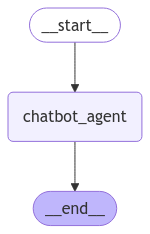

In [10]:
from IPython.display import Image, display
display(Image(graph_app.get_graph(xray=True).draw_mermaid_png()))


In [11]:
def stream_graph_updates(user_input: str):
    is_finished = False
    for event in graph_app.stream({"messages": [("user", user_input)]}):
        # Each `event` is typically a dict keyed by node name, e.g.: {"search_agent": {...}}
        for value in event.values():
            # "value" might look like: {"messages": [AIMessage(...)]}
            last_msg = value["messages"][-1]

            # Display the chunk
            display(Markdown("Assistant: " + last_msg.content))

            # Check for finish_reason in the last_msg
            finish_reason = last_msg.response_metadata.get("finish_reason")
            if finish_reason == "stop":
                is_finished = True
                break
        if is_finished:
            break

while True:
    try:
        user_input = input('User:')
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Thank you and Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What are the top AI Agents in the world right now?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:What is biggest planet in our galaxy?


Assistant: The largest planet in our solar system (not galaxy, as galaxies are collections of stars, stellar remnants, interstellar gas, dust, and dark matter, and our solar system is just one of many within the Milky Way galaxy) is Jupiter.

Jupiter is a gas giant, meaning it is primarily composed of hydrogen and helium gases. It has a diameter of approximately 142,984 kilometers (88,846 miles), which is more than 11 times the diameter of the Earth. Jupiter is also the most massive planet in our solar system, with a mass of approximately 318 times that of Earth.

It's worth noting that while Jupiter is the largest planet in our solar system, there are other planets in other star systems that are even larger. These are known as exoplanets, and some of them are truly massive, with sizes rivaling that of small stars. However, within our own solar system, Jupiter remains the largest planet.

User:What is the top 5 LLMs right now?


Assistant: The ranking of the top Large Language Models (LLMs) can vary depending on the criteria used, such as performance on specific benchmarks, model size, and application areas. However, based on recent research and developments, here are five of the most notable LLMs:

1. **LLaMA (Large Language Model Meta AI)**: Developed by Meta AI, LLaMA is a state-of-the-art LLM that has achieved impressive results on various natural language processing (NLP) tasks, including language translation, question answering, and text generation.
2. **PaLM (Pathways Language Model)**: Developed by Google, PaLM is a massive LLM that has demonstrated exceptional performance on a wide range of NLP tasks, including language understanding, generation, and conversation.
3. **BERT (Bidirectional Encoder Representations from Transformers)**: Developed by Google, BERT is a highly influential LLM that has become a standard baseline for many NLP tasks. Its success has led to the development of various BERT-based models, such as RoBERTa and DistilBERT.
4. **ChatGPT (Chat Generative Pre-trained Transformer)**: Developed by OpenAI, ChatGPT is a conversational AI model that has gained significant attention for its ability to engage in human-like conversations and generate coherent text.
5. **GLM (General Language Model)**: Developed by Tsinghua University, GLM is a large-scale LLM that has achieved impressive results on various NLP tasks, including language translation, question answering, and text generation. GLM has also been used in various applications, such as chatbots and language translation systems.

Please note that the ranking of LLMs can change rapidly as new models are developed and released. Additionally, the performance of LLMs can vary depending on the specific task or application, so this list is not exhaustive, and other models may be more suitable for specific use cases.

User:What is the weather in Paris today?


Assistant: I'm a large language model, I don't have real-time access to current weather conditions. But I can suggest some ways for you to find out the current weather in Paris:

1. Check online weather websites: You can visit websites like AccuWeather, Weather.com, or the French national meteorological service, Météo-France, to get the current weather conditions in Paris.
2. Use a weather app: You can download a weather app on your smartphone, such as Dark Sky or Weather Underground, to get the current weather conditions in Paris.
3. Search on a search engine: You can simply type "Paris weather today" or "Paris weather now" in a search engine like Google to get the current weather conditions.

Please note that the weather can change rapidly, so it's always a good idea to check the latest forecast before planning your day.

User:Quit
Thank you and Goodbye!


# Second Agent: Add Search to Chatbot to make it Stronger

In [12]:
from langchain_community.tools import GoogleSerperResults
from typing import List, Annotated
from langchain_core.messages import BaseMessage
from langgraph.prebuilt import ToolNode, create_react_agent
import operator
import functools

class ChatState(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

def agent_node(state, agent, name):
    result = agent.invoke(state)
    print("DEBUG: agent returned:", result)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }


class SearchState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]

# Search Tool

serper_tool = GoogleSerperResults(
    num_results=5,
    # how many Google results to return
)

search_agent = create_react_agent(llm, tools=[serper_tool])
search_node = functools.partial(agent_node,
                                agent=search_agent,
                                name="search_agent")


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
search_graph = StateGraph(SearchState)
search_graph.add_node("search_agent", search_node)
search_graph.add_edge(START, "search_agent")
search_graph.add_edge("search_agent", END)

# Finally, we'll want to be able to run our graph. To do so, call "compile()"
# We basically now give our AI Agent
search_app = search_graph.compile()





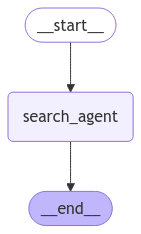

In [13]:
from IPython.display import Image, display
display(Image(search_app.get_graph(xray=True).draw_mermaid_png()))

In [15]:
def stream_graph_updates(user_input: str):
    is_finished = False
    for event in search_app.stream({"messages": [("user", user_input)]}):
        # Each `event` is typically a dict keyed by node name, e.g.: {"search_agent": {...}}
        for value in event.values():
            # "value" might look like: {"messages": [AIMessage(...)]}
            last_msg = value["messages"][-1]

            # Display the chunk
            display(Markdown("Assistant: " + last_msg.content))

            # Check for finish_reason in the last_msg
            finish_reason = last_msg.response_metadata.get("finish_reason")
            if finish_reason == "stop":
                is_finished = True
                break
        if is_finished:
            break

while True:
    try:
        user_input = input('User:')
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Thank you and Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What are the top AI Agents in the world right now?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:What are the top 5 LLMs right now and why?
DEBUG: agent returned: {'messages': [HumanMessage(content='What are the top 5 LLMs right now and why?', additional_kwargs={}, response_metadata={}, id='74559864-8c28-4ce3-8994-fd25865cf7d2'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hn6m', 'function': {'arguments': '{"query": "top 5 LLMs 2024"}', 'name': 'google_serper_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 288, 'total_tokens': 314, 'completion_time': 0.123852223, 'prompt_time': 0.051329489, 'queue_time': 0.018172700000000007, 'total_time': 0.175181712}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3884478861', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c87e7d3a-c0cf-419c-9335-f64698c661f8-0', tool_calls=[{'name': 'google_serper_results_json', 'args': {'query': 'top 5 LLMs 2024'}, 'id': 'call_hn6m', 'type': 'tool_call'}], usage_metadata={'input_toke

Assistant: Based on the search results, the top 5 LLMs right now are:

1. GPT-4o
2. Claude 3.5
3. Grok-1
4. Mistral 7B
5. PaLM 2

These LLMs are considered to be among the best due to their high performance, accuracy, and ability to handle complex tasks. However, it's worth noting that the ranking of LLMs can vary depending on the specific use case and criteria used to evaluate them.

User:How is the weather in Utrecht, Netherlands today?
DEBUG: agent returned: {'messages': [HumanMessage(content='How is the weather in Utrecht, Netherlands today?', additional_kwargs={}, response_metadata={}, id='eaf78b4b-b187-416a-b660-14afe82c3284'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_n19b', 'function': {'arguments': '{"query": "Utrecht Netherlands weather today"}', 'name': 'google_serper_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 285, 'total_tokens': 307, 'completion_time': 0.08, 'prompt_time': 0.041107474, 'queue_time': 0.021193576, 'total_time': 0.121107474}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_4e32347616', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3a9a73e2-868e-43a6-8579-c49e0c864bbf-0', tool_calls=[{'name': 'google_serper_results_json', 'args': {'query': 'Utrecht Netherlands weather today'}, 'id': 'call_n19b', 'type': 'tool_ca

Assistant: The current weather in Utrecht, Netherlands today is mostly cloudy with a high of 41°F (5°C) and a low of 32°F (0°C). There is a 30% chance of rain.

User:What are the top 3 articles about RAG on Arxiv? Show also their URL links
DEBUG: agent returned: {'messages': [HumanMessage(content='What are the top 3 articles about RAG on Arxiv? Show also their URL links', additional_kwargs={}, response_metadata={}, id='85a3dff7-da1b-450b-bda5-2234723a91f6'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1gk7', 'function': {'arguments': '{"query": "RAG arxiv"}', 'name': 'google_serper_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 293, 'total_tokens': 314, 'completion_time': 0.100029107, 'prompt_time': 0.050712802, 'queue_time': 0.021167634000000005, 'total_time': 0.150741909}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3884478861', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-93e996ad-c9ab-4793-a885-e60a4d758e22-0', tool_calls=[{'name': 'google_serper_results_json', 'args': {'query': 'RAG arxiv'}, 'id': 'call_1gk7', 

Assistant: The top 3 articles about RAG on Arxiv are:

1. "Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks" - https://arxiv.org/abs/2005.11401
2. "Retrieval-Augmented Generation for Large Language Models" - https://arxiv.org/abs/2312.10997
3. "A Comprehensive Survey of Retrieval-Augmented Generation (RAG)" - https://arxiv.org/abs/2410.12837

These articles can be found on the Arxiv website, and their URLs are provided above.

User:Search Arxiv for the latest RAG articles please
DEBUG: agent returned: {'messages': [HumanMessage(content='Search Arxiv for the latest RAG articles please', additional_kwargs={}, response_metadata={}, id='e752bf53-5c77-449a-86ca-f2cf41c4110d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_nbwn', 'function': {'arguments': '{"query": "RAG articles Arxiv"}', 'name': 'google_serper_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 284, 'total_tokens': 306, 'completion_time': 0.105102492, 'prompt_time': 0.055415586, 'queue_time': 0.016663060999999993, 'total_time': 0.160518078}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_c0cfa69934', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fad8e186-229d-4efb-b4b9-0b332363c87b-0', tool_calls=[{'name': 'google_serper_results_json', 'args': {'query': 'RAG articles Arxiv'}, 'id': 'call_nbwn', 'type': 'tool_call'}], usage_metad

Assistant: Here are the latest RAG articles on Arxiv:

1. "Retrieval-Augmented Generation for Large Language Models" (Dec 18, 2023)
2. "Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks" (May 22, 2020)
3. "A Comprehensive Survey of Retrieval-Augmented Generation (RAG)" (Oct 3, 2024)
4. "Auto-RAG: Autonomous Retrieval-Augmented Generation for Large Language Models" (Nov 29, 2024)
5. "Enhancing Retrieval-Augmented Generation: A Study of Best Practices" (Jan 13, 2025)
6. "Retrieval-Augmented Generation with Graphs (GraphRAG)" (Dec 31, 2024)
7. "Open-RAG: Enhanced Retrieval-Augmented Reasoning with Open-Source LLMs" (Oct 2, 2024)
8. "Retrieval Augmented Generation or Long-Context LLMs? A Comparative Study" (Jul 23, 2024)
9. "Retrieval Augmented Generation (RAG) and Beyond" (Sep 23, 2024)

You can find the links to these articles and more information on the Arxiv website.

User:Quit
Thank you and Goodbye!


# Step 1: Medical Database Preparation
This step involves preparing and enhancing patient data to be used throughout the simulation.

## 1.1 Load Dataset

### 1.1.1  Disease Symptoms and Patient Profile Dataset
Ensure you have downloaded it and placed it in your project directory.
- https://www.kaggle.com/datasets/uom190346a/disease-symptoms-and-patient-profile-dataset

In [16]:
# Download latest version
path = kagglehub.dataset_download("uom190346a/disease-symptoms-and-patient-profile-dataset")
print("Path to dataset files:", path)

100%|██████████| 3.07k/3.07k [00:00<00:00, 2.31MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/uom190346a/disease-symptoms-and-patient-profile-dataset/versions/2


In [17]:
patient_df = pd.read_csv(path+'/Disease_symptom_and_patient_profile_dataset.csv')
patient_df.shape

(349, 10)

In [19]:
patient_df.head()

,Disease,Fever,Cough,Fatigue,Difficulty Breathing,Age,Gender,Blood Pressure,Cholesterol Level,Outcome Variable
0,Influenza,Yes,No,Yes,Yes,19,Female,Low,Normal,Positive
1,Common Cold,No,Yes,Yes,No,25,Female,Normal,Normal,Negative
2,Eczema,No,Yes,Yes,No,25,Female,Normal,Normal,Negative
3,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive
4,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive


In [20]:
# Calculate the counts of each gender
female_count = patient_df[patient_df['Gender'] == 'Female'].shape[0]
male_count = patient_df[patient_df['Gender'] == 'Male'].shape[0]

# Calculate the ratio
ratio = female_count / male_count
print(f"The ratio of Female to Male is {ratio}:1")

The ratio of Female to Male is 1.0173410404624277:1


In [21]:
patient_df['Disease'].value_counts().head(20)

,count
Disease,
Asthma,23
Stroke,16
Osteoporosis,14
Hypertension,10
Diabetes,10
Migraine,10
Influenza,8
Pneumonia,8
Bronchitis,8


**prepare_medical_dataset Code in One Plalce**

In [22]:
def prepare_medical_dataset(path, file_name):
  patient_df = pd.read_csv(path+file_name)
  return patient_df

path = kagglehub.dataset_download("uom190346a/disease-symptoms-and-patient-profile-dataset")
file_name = '/Disease_symptom_and_patient_profile_dataset.csv'
patient_df = prepare_medical_dataset(path, file_name)

### 1.1.2 Chest X-Ray Images (Pneumonia)

- https://huggingface.co/lxyuan/vit-xray-pneumonia-classification
- https://huggingface.co/datasets/keremberke/chest-xray-classification



In [23]:
from datasets import load_dataset
patient_x_ray_path = "keremberke/chest-xray-classification"
x_ray_ds = load_dataset(patient_x_ray_path, name="full")
random_index = random.randint(0, x_ray_ds['train'].shape[0] - 1)
patient_x_ray = random_row = x_ray_ds['train'][random_index]['image']

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

chest-xray-classification.py:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/144M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/41.3M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/20.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4077 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1165 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/582 [00:00<?, ? examples/s]

In [24]:
x_ray_ds['train'].shape[0]

4077

In [25]:
# Assuming x_ray_ds['train'] is a dataset where we want to pick a random row
import random
random_index = random.randint(0, x_ray_ds['train'].shape[0] - 1)

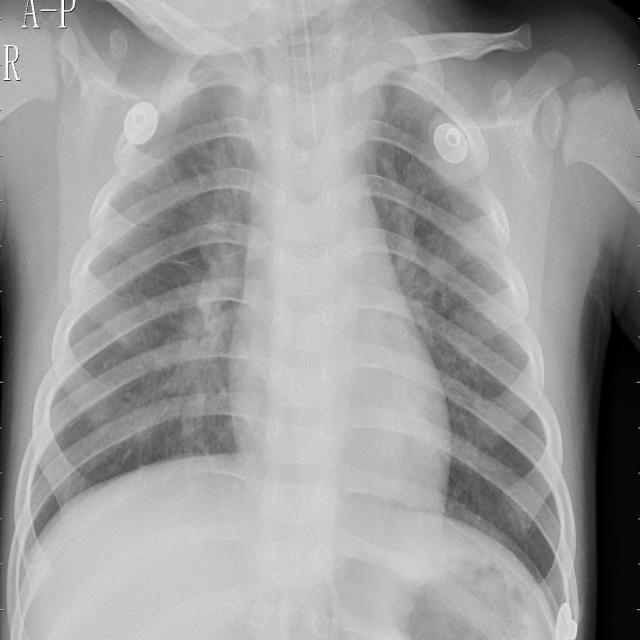

In [26]:
patient_x_ray = x_ray_ds['train'][random_index]['image']
patient_x_ray

In [27]:
type(patient_x_ray)

PIL.JpegImagePlugin.JpegImageFile

In [28]:
from transformers import pipeline

# Model in Hugging Face: https://huggingface.co/lxyuan/vit-xray-pneumonia-classification
# vit-xray-pneumonia-classification
classifier = pipeline(model="lxyuan/vit-xray-pneumonia-classification")
patient_x_ray_results = classifier(patient_x_ray)
patient_x_ray_results


config.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Device set to use cpu


[{'label': 'PNEUMONIA', 'score': 0.6894433498382568},
 {'label': 'NORMAL', 'score': 0.3072775602340698}]

In [29]:
# Find the label with the highest score
patient_x_ray_label = max(patient_x_ray_results, key=lambda x: x['score'])['label']
print(patient_x_ray_label)

PNEUMONIA


In [30]:
# Model in Hugging Face: https://huggingface.co/lxyuan/vit-xray-pneumonia-classification
# vit-xray-pneumonia-classification
classifier = pipeline(model="lxyuan/vit-xray-pneumonia-classification")
patient_x_ray_results = classifier(patient_x_ray)

# Find the label with the highest score and its score
highest = max(patient_x_ray_results, key=lambda x: x['score'])
highest_score_label = highest['label']
highest_score = highest['score'] * 100  # Convert to percentage

# Choose the correct verb based on the label
verb = "is" if highest_score_label == "NORMAL" else "has"

# Print the result dynamically
print(f"Patient {verb} {highest_score_label} with Probability of ca. {highest_score:.0f}%")

Device set to use cpu


Patient has PNEUMONIA with Probability of ca. 69%


## 1.2 Generate Synthetic Data with LLMs
Generate culturally appropriate Dutch names and unique alphanumeric IDs for each patient.

### 1.2.1 Generate Random Names and IDs for Patience

This Code Goes Slower because of Llama 3.3 70b being very big and slow LLM
comparing to llama 3.2 11b
Switch to model_3_2_smal when running this code

In [31]:
# === Step 1: Define Response Schemas ===
# Define the structure of the expected JSON output.

# ResponseSchema for First_Name
first_name_schema = ResponseSchema(
    name="First_Name",
    description="The first name of the patient."
)

# ResponseSchema for Last_Name
last_name_schema = ResponseSchema(
    name="Last_Name",
    description="The last name of the patient."
)

# ResponseSchema for Patient_ID
patient_id_schema = ResponseSchema(
    name="Patient_ID",
    description="A unique 13-character alphanumeric patient identifier."
)

# ResponseSchema for Patient_ID
gender_schema = ResponseSchema(
    name="G_Gender",
    description="Indicate the first name you generate belong which Gender: Male or Female"
)

# Aggregate all response schemas
response_schemas = [
    first_name_schema,
    last_name_schema,
    patient_id_schema,
    gender_schema
]

# === Step 2: Set Up the Output Parser ===
# Initialize the StructuredOutputParser with the defined response schemas.

output_parser = StructuredOutputParser.from_response_schemas(response_schemas)

# Get the format instructions to include in the prompt
format_instructions = output_parser.get_format_instructions()

# === Step 3: Craft the Prompt ===
# Create a prompt that instructs the LLM to generate only the structured JSON data.

# Define the prompt template using ChatPromptTemplate
prompt_template = ChatPromptTemplate.from_template("""
you MUST Generate a list of {n} Dutch names along with a unique 13-character alphanumeric Patient_ID for each gender provided.
Always Use {genders} to generate a First_Name which belong to the right Gender, two category is possible: 'Male' or 'Female'.
Ensure the names are culturally appropriate for the Netherlands.
Generate unique names, no repetitions, and ensure diversity.
The ratio of Female to Male is {ratio}:1

{format_instructions}

Genders:
{genders}

**IMPORTANT:** Do not include any explanations, code, or additional text.
you MUST ALWAYS generate Dutch names and Patient_ID according {format_instructions}
and NEVER return empty values.
YOU MUST Provide only the JSON array as specified.
JSON array Should have exactly {n} rows and 3 columns
""")

# Determine the number of patients
n_patients = len(patient_df)
#n_patients = 120
# Calculate the counts of each gender
female_count = patient_df[patient_df['Gender'] == 'Female'].shape[0]
male_count = patient_df[patient_df['Gender'] == 'Male'].shape[0]

# Calculate the ratio
ratio = female_count / male_count

# Prepare the list of genders
genders = patient_df['Gender'].tolist()

# === Step 6: Generate the Prompt ===
# Format the prompt with the number of patients and their genders.

formatted_prompt = prompt_template.format(
    n=n_patients,
    ratio = ratio,
    genders=', '.join(genders),
    format_instructions=format_instructions
)

# Invoke the model with s Smaller Llama Model for Speed
model_3_2_small = 'llama-3.2-3b-preview' # if you need speed

llm = ChatGroq(
    model= model_3_2_small, #
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
)

output = llm.invoke(formatted_prompt, timeout=1000)


In [32]:
display(Markdown(output.content))

```json
[
  {
    "First_Name": "Anouk", 
    "Last_Name": "van", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Sander", 
    "Last_Name": "Jansen", 
    "Patient_ID": "BnM8dLpM2K3aG4eJ", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Liesbeth", 
    "Last_Name": "Doe", 
    "Patient_ID": "aBnC9eJ8dLpM2K3G4", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Maarten", 
    "Last_Name": "Pieters", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9e", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Saskia", 
    "Last_Name": "van", 
    "Patient_ID": "BnM8dLpM2K3aG4eJ8", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Stijn", 
    "Last_Name": "Janssen", 
    "Patient_ID": "aBnC9eJ8dLpM2K3G4e", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Femke", 
    "Last_Name": "Doe", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Rens", 
    "Last_Name": "Pieters", 
    "Patient_ID": "BnM8dLpM2K3aG4eJ8d", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Nina", 
    "Last_Name": "van", 
    "Patient_ID": "aBnC9eJ8dLpM2K3G4eJ", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Tim", 
    "Last_Name": "Jansen", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Linda", 
    "Last_Name": "Doe", 
    "Patient_ID": "BnM8dLpM2K3aG4eJ8dL", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Sjoerd", 
    "Last_Name": "Pieters", 
    "Patient_ID": "aBnC9eJ8dLpM2K3G4eJ8", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Fleur", 
    "Last_Name": "van", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8d", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Maarten", 
    "Last_Name": "Janssen", 
    "Patient_ID": "BnM8dLpM2K3aG4eJ8dL", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Saskia", 
    "Last_Name": "Doe", 
    "Patient_ID": "aBnC9eJ8dLpM2K3G4eJ8d", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Stijn", 
    "Last_Name": "Janssen", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8dL", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Femke", 
    "Last_Name": "Pieters", 
    "Patient_ID": "BnM8dLpM2K3aG4eJ8dLp", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Rens", 
    "Last_Name": "van", 
    "Patient_ID": "aBnC9eJ8dLpM2K3G4eJ8dLp", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Nina", 
    "Last_Name": "Jansen", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8dLp", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Tim", 
    "Last_Name": "Doe", 
    "Patient_ID": "BnM8dLpM2K3aG4eJ8dLpM", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Linda", 
    "Last_Name": "Pieters", 
    "Patient_ID": "aBnC9eJ8dLpM2K3G4eJ8dLpM", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Sjoerd", 
    "Last_Name": "Janssen", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8dLpM", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Fleur", 
    "Last_Name": "van", 
    "Patient_ID": "BnM8dLpM2K3aG4eJ8dLpM2", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Maarten", 
    "Last_Name": "Doe", 
    "Patient_ID": "aBnC9eJ8dLpM2K3G4eJ8dLpM2", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Saskia", 
    "Last_Name": "Jansen", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8dLpM2", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Stijn", 
    "Last_Name": "Pieters", 
    "Patient_ID": "BnM8dLpM2K3aG4eJ8dLpM2K", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Femke", 
    "Last_Name": "van", 
    "Patient_ID": "aBnC9eJ8dLpM2K3G4eJ8dLpM2K", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Rens", 
    "Last_Name": "Janssen", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8dLpM2K", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Nina", 
    "Last_Name": "Doe", 
    "Patient_ID": "BnM8dLpM2K3aG4eJ8dLpM2K3", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Tim", 
    "Last_Name": "Pieters", 
    "Patient_ID": "aBnC9eJ8dLpM2K3G4eJ8dLpM2K3", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Linda", 
    "Last_Name": "van", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8dLpM2K3", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Sjoerd", 
    "Last_Name": "Janssen", 
    "Patient_ID": "BnM8dLpM2K3aG4eJ8dLpM2K3", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Fleur", 
    "Last_Name": "Doe", 
    "Patient_ID": "aBnC9eJ8dLpM2K3G4eJ8dLpM2K3e", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Maarten", 
    "Last_Name": "Pieters", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8dLpM2K3e", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Saskia", 
    "Last_Name": "Jansen", 
    "Patient_ID": "BnM8dLpM2K3aG4eJ8dLpM2K3e", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Stijn", 
    "Last_Name": "van", 
    "Patient_ID": "aBnC9eJ8dLpM2K3G4eJ8dLpM2K3e", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Femke", 
    "Last_Name": "Doe", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8dLpM2K3eJ", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Rens", 
    "Last_Name": "Pieters", 
    "Patient_ID": "BnM8dLpM2K3aG4eJ8dLpM2K3eJ", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Nina", 
    "Last_Name": "Janssen", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8dLpM2K3eJ", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Tim", 
    "Last_Name": "van", 
    "Patient_ID": "aBnC9eJ8dLpM2K3G4eJ8dLpM2K3eJ", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Linda", 
    "Last_Name": "Doe", 
    "Patient_ID": "BnM8dLpM2K3aG4eJ8dLpM2K3eJL", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Sjoerd", 
    "Last_Name": "Pieters", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8dLpM2K3eJL", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Fleur", 
    "Last_Name": "Jansen", 
    "Patient_ID": "aBnC9eJ8dLpM2K3G4eJ8dLpM2K3eJL", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Maarten", 
    "Last_Name": "van", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8dLpM2K3eJL", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Saskia", 
    "Last_Name": "Doe", 
    "Patient_ID": "BnM8dLpM2K3aG4eJ8dLpM2K3eJLp", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Stijn", 
    "Last_Name": "Pieters", 
    "Patient_ID": "aBnC9eJ8dLpM2K3G4eJ8dLpM2K3eJLp", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Femke", 
    "Last_Name": "Janssen", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8dLpM2K3eJLp", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Rens", 
    "Last_Name": "van", 
    "Patient_ID": "BnM8dLpM2K3aG4eJ8dLpM2K3eJLp", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Nina", 
    "Last_Name": "Doe", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8dLpM2K3eJLpp", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Tim", 
    "Last_Name": "Pieters", 
    "Patient_ID": "aBnC9eJ8dLpM2K3G4eJ8dLpM2K3eJLpp", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Linda", 
    "Last_Name": "Jansen", 
    "Patient_ID": "BnM8dLpM2K3aG4eJ8dLpM2K3eJLpp", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Sjoerd", 
    "Last_Name": "van", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8dLpM2K3eJLpp", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Fleur", 
    "Last_Name": "Doe", 
    "Patient_ID": "aBnC9eJ8dLpM2K3G4eJ8dLpM2K3eJLppp", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Maarten", 
    "Last_Name": "Pieters", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8dLpM2K3eJLppp", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Saskia", 
    "Last_Name": "Jansen", 
    "Patient_ID": "BnM8dLpM2K3aG4eJ8dLpM2K3eJLppp", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Stijn", 
    "Last_Name": "van", 
    "Patient_ID": "aBnC9eJ8dLpM2K3G4eJ8dLpM2K3eJLpppp", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Femke", 
    "Last_Name": "Doe", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8dLpM2K3eJLpppp", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Rens", 
    "Last_Name": "Pieters", 
    "Patient_ID": "BnM8dLpM2K3aG4eJ8dLpM2K3eJLpppp", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Nina", 
    "Last_Name": "Janssen", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8dLpM2K3eJLpppp", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Tim", 
    "Last_Name": "van", 
    "Patient_ID": "aBnC9eJ8dLpM2K3G4eJ8dLpM2K3eJLppppp", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Linda", 
    "Last_Name": "Doe", 
    "Patient_ID": "BnM8dLpM2K3aG4eJ8dLpM2K3eJLpppppp", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Sjoerd", 
    "Last_Name": "Pieters", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8dLpM2K3eJLpppppp", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Fleur", 
    "Last_Name": "Jansen", 
    "Patient_ID": "aBnC9eJ8dLpM2K3G4eJ8dLpM2K3eJLpppppp", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Maarten", 
    "Last_Name": "van", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8dLpM2K3eJLpppppp", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Saskia", 
    "Last_Name": "Doe", 
    "Patient_ID": "BnM8dLpM2K3aG4eJ8dLpM2K3eJLppppppp", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Stijn", 
    "Last_Name": "Pieters", 
    "Patient_ID": "aBnC9eJ8dLpM2K3G4eJ8dLpM2K3eJLppppppp", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Femke", 
    "Last_Name": "Janssen", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8dLpM2K3eJLppppppp", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Rens", 
    "Last_Name": "van", 
    "Patient_ID": "BnM8dLpM2K3aG4eJ8dLpM2K3eJLppppppp", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Nina", 
    "Last_Name": "Doe", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8dLpM2K3eJLpppppppp", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Tim", 
    "Last_Name": "Pieters", 
    "Patient_ID": "aBnC9eJ8dLpM2K3G4eJ8dLpM2K3eJLpppppppp", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Linda", 
    "Last_Name": "Jansen", 
    "Patient_ID": "BnM8dLpM2K3aG4eJ8dLpM2K3eJLpppppppp", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Sjoerd", 
    "Last_Name": "van", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8dLpM2K3eJLpppppppp", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Fleur", 
    "Last_Name": "Doe", 
    "Patient_ID": "aBnC9eJ8dLpM2K3G4eJ8dLpM2K3eJLppppppppp", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Maarten", 
    "Last_Name": "Pieters", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8dLpM2K3eJLppppppppp", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Saskia", 
    "Last_Name": "Jansen", 
    "Patient_ID": "BnM8dLpM2K3aG4eJ8dLpM2K3eJLppppppppp", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Stijn", 
    "Last_Name": "van", 
    "Patient_ID": "aBnC9eJ8dLpM2K3G4eJ8dLpM2K3eJLpppppppppp", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Femke", 
    "Last_Name": "Doe", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8dLpM2K3eJLpppppppppp", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Rens", 
    "Last_Name": "Pieters", 
    "Patient_ID": "BnM8dLpM2K3aG4eJ8dLpM2K3eJLpppppppppp", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Nina", 
    "Last_Name": "Janssen", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8dLpM2K3eJLpppppppppp", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Tim", 
    "Last_Name": "van", 
    "Patient_ID": "aBnC9eJ8dLpM2K3G4eJ8dLpM2K3eJLppppppppppp", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Linda", 
    "Last_Name": "Doe", 
    "Patient_ID": "BnM8dLpM2K3aG4eJ8dLpM2K3eJLppppppppppp", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Sjoerd", 
    "Last_Name": "Pieters", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8dLpM2K3eJLppppppppppp", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Fleur", 
    "Last_Name": "Jansen", 
    "Patient_ID": "aBnC9eJ8dLpM2K3G4eJ8dLpM2K3eJLpppppppppppp", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Maarten", 
    "Last_Name": "van", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8dLpM2K3eJLpppppppppppp", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Saskia", 
    "Last_Name": "Doe", 
    "Patient_ID": "BnM8dLpM2K3aG4eJ8dLpM2K3eJLppppppppppppp", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Stijn", 
    "Last_Name": "Pieters", 
    "Patient_ID": "aBnC9eJ8dLpM2K3G4eJ8dLpM2K3eJLppppppppppppp", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Femke", 
    "Last_Name": "Janssen", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8dLpM2K3eJLpppppppppppppp", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Rens", 
    "Last_Name": "van", 
    "Patient_ID": "BnM8dLpM2K3aG4eJ8dLpM2K3eJLpppppppppppppp", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Nina", 
    "Last_Name": "Doe", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8dLpM2K3eJLpppppppppppppp", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Tim", 
    "Last_Name": "Pieters", 
    "Patient_ID": "aBnC9eJ8dLpM2K3G4eJ8dLpM2K3eJLpppppppppppppp", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "Linda", 
    "Last_Name": "Jansen", 
    "Patient_ID": "BnM8dLpM2K3aG4eJ8dLpM2K3eJLppppppppppppppp", 
    "G_Gender": "Female"
  },
  {
    "First_Name": "Sjoerd", 
    "Last_Name": "van", 
    "Patient_ID": "G4eJ8dLpM2K3aBnC9eJ8dLpM2K3eJLppppppppppppppp", 
    "G_Gender": "Male"
  },
  {
    "First_Name": "

In [33]:
output_parser = JsonOutputParser()
json_output = output_parser.invoke(output)
json_output

[{'First_Name': 'Anouk',
  'Last_Name': 'van',
  'Patient_ID': 'G4eJ8dLpM2K3aBnC9',
  'G_Gender': 'Female'},
 {'First_Name': 'Sander',
  'Last_Name': 'Jansen',
  'Patient_ID': 'BnM8dLpM2K3aG4eJ',
  'G_Gender': 'Male'},
 {'First_Name': 'Liesbeth',
  'Last_Name': 'Doe',
  'Patient_ID': 'aBnC9eJ8dLpM2K3G4',
  'G_Gender': 'Female'},
 {'First_Name': 'Maarten',
  'Last_Name': 'Pieters',
  'Patient_ID': 'G4eJ8dLpM2K3aBnC9e',
  'G_Gender': 'Male'},
 {'First_Name': 'Saskia',
  'Last_Name': 'van',
  'Patient_ID': 'BnM8dLpM2K3aG4eJ8',
  'G_Gender': 'Female'},
 {'First_Name': 'Stijn',
  'Last_Name': 'Janssen',
  'Patient_ID': 'aBnC9eJ8dLpM2K3G4e',
  'G_Gender': 'Male'},
 {'First_Name': 'Femke',
  'Last_Name': 'Doe',
  'Patient_ID': 'G4eJ8dLpM2K3aBnC9eJ',
  'G_Gender': 'Female'},
 {'First_Name': 'Rens',
  'Last_Name': 'Pieters',
  'Patient_ID': 'BnM8dLpM2K3aG4eJ8d',
  'G_Gender': 'Male'},
 {'First_Name': 'Nina',
  'Last_Name': 'van',
  'Patient_ID': 'aBnC9eJ8dLpM2K3G4eJ',
  'G_Gender': 'Female'},
 

In [34]:
all_patients = []
generated_patients = pd.DataFrame(json_output)
generated_patients.head(5)

,First_Name,Last_Name,Patient_ID,G_Gender
0,Anouk,van,G4eJ8dLpM2K3aBnC9,Female
1,Sander,Jansen,BnM8dLpM2K3aG4eJ,Male
2,Liesbeth,Doe,aBnC9eJ8dLpM2K3G4,Female
3,Maarten,Pieters,G4eJ8dLpM2K3aBnC9e,Male
4,Saskia,van,BnM8dLpM2K3aG4eJ8,Female


In [35]:
generated_patients.shape

(93, 4)

In [36]:
# Adjusted LLM parameters (if supported)
llm.temperature = 0.9  # Increases randomness

all_patients_name_id = pd.DataFrame()
output_parser = JsonOutputParser()

while all_patients_name_id.shape[0] < n_patients:
  output = llm.invoke(formatted_prompt)
  json_output = output_parser.invoke(output)
  generated_patients = pd.DataFrame(json_output)
  all_patients_name_id = pd.concat([generated_patients, all_patients_name_id], axis = 0)
  print(f"len all_patients_name_id: {len(all_patients_name_id)}")
  all_patients_name_id =  all_patients_name_id.drop_duplicates()
  print(f"len all_patients_name_id after droping duplicates: {len(all_patients_name_id)}")

len all_patients_name_id: 135
len all_patients_name_id after droping duplicates: 76
len all_patients_name_id: 170
len all_patients_name_id after droping duplicates: 170
len all_patients_name_id: 271
len all_patients_name_id after droping duplicates: 271
len all_patients_name_id: 397
len all_patients_name_id after droping duplicates: 397


In [37]:
all_patients_name_id.rename(columns = {"G_Gender": "Gender"}, inplace= True)
all_patients_name_id.head(10)

,First_Name,Last_Name,Patient_ID,Gender
0,Frida,Brouwer,R3X4P7M2O1D8G6H,NaN
1,Stefan,van der Meer,J9D6P1E3G7N5L2O9K,NaN
2,Liesbeth,Janssen,M4H8G3P1O9L6N2D7K8X,NaN
3,Maarten,Smit,K4L9P7E1D8X6G5V3B1N2O,NaN
4,Anneke,Bakker,V6E5G4O2D9K1H7N8L3P4X,NaN
5,Sander,Waardijk,E3D9P7N5O2G1L6X8V3B4R1Y,NaN
6,Sara,van den Heuvel,D9J6P2M1O8K7L8G3V4N1X,NaN
7,Rick,Plasman,J1E9P7N3L6O9X2V5K4G1D,NaN
8,Ingrid,Janssen,N8M5L9P4D1X7O2G3K4V3Y1E,NaN
9,Roy,van Oijen,G5X4W2Y9L8P3D1N2R6T8O,NaN


In [38]:
gender_counts = patient_df['Gender'].value_counts()
gender_counts

,count
Gender,
Female,176
Male,173


In [39]:
all_patients_name_id['Gender'].value_counts()

,count
Gender,
Male,140
Female,129


In [40]:
# Step 1: Count the number of males and females in patient_df
gender_counts = patient_df['Gender'].value_counts()

# Step 2: Select the required number of unique males and females from all_patients_name_id
unique_males = all_patients_name_id[all_patients_name_id['Gender'] == 'Male'].drop_duplicates().head(gender_counts['Male'])
unique_females = all_patients_name_id[all_patients_name_id['Gender'] == 'Female'].drop_duplicates().head(gender_counts['Female'])


patient_male = patient_df[patient_df['Gender'] == 'Male'].reset_index(drop=True)
patient_female = patient_df[patient_df['Gender'] == 'Female'].reset_index(drop=True)


updated_male_patients = pd.concat([patient_male.reset_index(drop=True),
                                   unique_males[0:patient_male.shape[0]].reset_index(drop=True)],
                                   axis = 1)

updated_female_patients = pd.concat([patient_female.reset_index(drop=True),
                                   unique_females[0:patient_female.shape[0]].reset_index(drop=True)],
                                   axis = 1)

# Step 3: Concatenate patient_df with the selected rows from all_patients_name_id
updated_patient_df = pd.concat([updated_male_patients, updated_female_patients], axis = 0)


In [41]:
updated_patient_df.shape[0]

349

In [42]:
# Display the final concatenated dataframe
updated_patient_df

,Disease,Fever,Cough,Fatigue,Difficulty Breathing,Age,Gender,Blood Pressure,Cholesterol Level,Outcome Variable,First_Name,Last_Name,Patient_ID,Gender
0,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive,Sjoerd,Wijnen,B12N8EV1K3M9C6L4G8J4J13F1,Male
1,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive,Freek,Veenhoven,C6N3E8B9J1M5G4L8T7V1J2F4,Male
2,Asthma,Yes,No,No,Yes,28,Male,High,Normal,Positive,Bart,Jansen,M9K7F1E8T6L4G8V1M5J4N1F2,Male
3,Diabetes,No,No,No,No,29,Male,Low,Normal,Negative,Gert,Meijer,M1F4E8T6L4G8V1M5J4N1F8,Male
4,Depression,Yes,Yes,Yes,Yes,29,Male,High,Normal,Positive,Cees,Hijmans,N1J2F4E8T6L4G8V1M5J4,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,Williams Syndrome,No,No,Yes,No,70,Female,Normal,Normal,Positive,NaN,NaN,NaN,NaN
172,Stroke,Yes,No,Yes,No,80,Female,High,High,Positive,NaN,NaN,NaN,NaN
173,Stroke,Yes,No,Yes,No,80,Female,High,High,Positive,NaN,NaN,NaN,NaN
174,Stroke,Yes,No,Yes,No,90,Female,High,High,Positive,NaN,NaN,NaN,NaN


In [43]:
updated_patient_df = updated_patient_df.loc[:, ~updated_patient_df.columns.duplicated()]
updated_patient_df

,Disease,Fever,Cough,Fatigue,Difficulty Breathing,Age,Gender,Blood Pressure,Cholesterol Level,Outcome Variable,First_Name,Last_Name,Patient_ID
0,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive,Sjoerd,Wijnen,B12N8EV1K3M9C6L4G8J4J13F1
1,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive,Freek,Veenhoven,C6N3E8B9J1M5G4L8T7V1J2F4
2,Asthma,Yes,No,No,Yes,28,Male,High,Normal,Positive,Bart,Jansen,M9K7F1E8T6L4G8V1M5J4N1F2
3,Diabetes,No,No,No,No,29,Male,Low,Normal,Negative,Gert,Meijer,M1F4E8T6L4G8V1M5J4N1F8
4,Depression,Yes,Yes,Yes,Yes,29,Male,High,Normal,Positive,Cees,Hijmans,N1J2F4E8T6L4G8V1M5J4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,Williams Syndrome,No,No,Yes,No,70,Female,Normal,Normal,Positive,NaN,NaN,NaN
172,Stroke,Yes,No,Yes,No,80,Female,High,High,Positive,NaN,NaN,NaN
173,Stroke,Yes,No,Yes,No,80,Female,High,High,Positive,NaN,NaN,NaN
174,Stroke,Yes,No,Yes,No,90,Female,High,High,Positive,NaN,NaN,NaN


In [44]:
updated_patient_df['Gender'].value_counts()

,count
Gender,
Female,176
Male,173


#### 1.2.1.1 Select a Random Patient

In [45]:
# Pick a Random Patient: A female between 20 and 29 and with Pneumonia as Positive so that later we can check X-Ray Agent
mask = (updated_patient_df['Gender'] == 'Female') & \
       (updated_patient_df["Age"].between(20, 29)) & \
        (updated_patient_df['Difficulty Breathing'] == 'Yes') & \
         (updated_patient_df['Outcome Variable'] == 'Positive')
selected_patients = updated_patient_df[mask].reset_index(drop=True)
selected_patients.head()

,Disease,Fever,Cough,Fatigue,Difficulty Breathing,Age,Gender,Blood Pressure,Cholesterol Level,Outcome Variable,First_Name,Last_Name,Patient_ID
0,Influenza,Yes,Yes,Yes,Yes,25,Female,Normal,Normal,Positive,Mirjam,Vanderhoeven,T2V4M5B6G4L8J4L1F7J2
1,Influenza,Yes,Yes,Yes,Yes,25,Female,Normal,Normal,Positive,Lotte,Dolleman,T6L4G8V1M5J4N1F7E9
2,Liver Cancer,Yes,Yes,Yes,Yes,29,Female,Normal,Normal,Positive,Grietje,Klaassen,F2W85HNJ4E1T6J4L9M8V1N5F2
3,Stroke,Yes,Yes,Yes,Yes,29,Female,Normal,Normal,Positive,AnneMarie,Robben,J1T9E2V4M5B6G4L8J4L1F8R


In [46]:
selected_patient = selected_patients.iloc[0]
selected_patient

,0
Disease,Influenza
Fever,Yes
Cough,Yes
Fatigue,Yes
Difficulty Breathing,Yes
Age,25
Gender,Female
Blood Pressure,Normal
Cholesterol Level,Normal
Outcome Variable,Positive


# Step 2: Create IDentity Photo for the Front Desk Agent

## 2.1 Build the Vision Model for Gender Classification (Image Classification Task)

In [47]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("image-classification", model="rizvandwiki/gender-classification")

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Device set to use cpu


In [48]:
# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("rizvandwiki/gender-classification")
model = AutoModelForImageClassification.from_pretrained("rizvandwiki/gender-classification")

In machine learning, particularly in classification tasks, logits are the raw, unnormalized outputs produced by a model's final layer before any activation function is applied. These outputs represent the model's confidence scores for each class and are essential for subsequent probability calculations.

In [49]:
from transformers import AutoModelForImageClassification, AutoProcessor
from PIL import Image
import requests

# Load the model and processor
model_name = "rizvandwiki/gender-classification"
model = AutoModelForImageClassification.from_pretrained(model_name)
processor = AutoProcessor.from_pretrained(model_name)

# Load the image from URL or local path
image_url = "https://thispersondoesnotexist.com"
image = Image.open(requests.get(image_url, stream=True).raw)

# Prepare the image for the model
inputs = processor(images=image, return_tensors="pt")

# Perform inference
outputs = model(**inputs)
logits = outputs.logits
predicted_class = logits.argmax(-1).item()

# Map prediction to class label
classes = model.config.id2label
gender_label = classes[predicted_class]

print(f"Predicted Gender: {gender_label}")


Predicted Gender: female


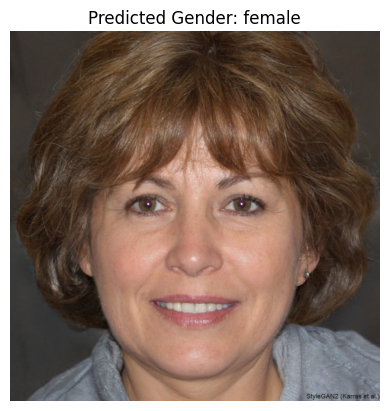

In [50]:
import matplotlib.pyplot as plt

# Display the image and prediction
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title(f"Predicted Gender: {gender_label}")
plt.show()


## 2.2 Build the Vision Model for Age Classification (Image Classification Task)

In [51]:
# Load age classification model
age_model_name = "nateraw/vit-age-classifier"
age_model = AutoModelForImageClassification.from_pretrained(age_model_name)
age_processor = AutoProcessor.from_pretrained(age_model_name)

config.json:   0%|          | 0.00/850 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/197 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [52]:
# Age Prediction
age_inputs = age_processor(images=image, return_tensors="pt")
age_outputs = age_model(**age_inputs)
age_logits = age_outputs.logits
age_prediction = age_logits.argmax(-1).item()
age_label = age_model.config.id2label[age_prediction]
age_label

'50-59'

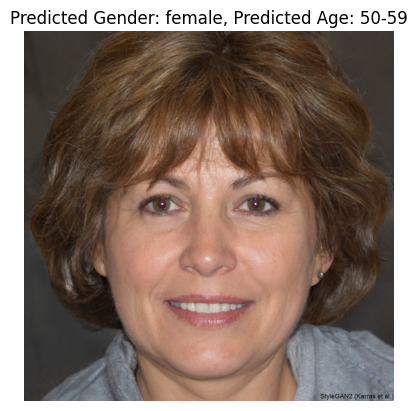

In [53]:
# Display the image with both predictions
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted Gender: {gender_label}, Predicted Age: {age_label}")
plt.show()

# Step 3: Start Building Multi-Agents

Define Each AI Agent
We'll define agents for:

* Administration Front Desk
* Physician for General Health Examination + Blood Laboratory
* X-Ray Image Department

## 3.1 Hospital Front Desk Agent



**--IMPORTANT NOTE--** <br>
1. Don't forget to save one photo from https://thispersondoesnotexist.com/
<br>  as female.jpg and save it to this Path "/content/sample_data/'
<br> which is standard path within your Google Colab

---
2. Don't Forget to Save one of the images from the x-ray-dataset <br>**Load Dataset in this way:** <br>
patient_x_ray_path = "keremberke/chest-xray-classification" <br>
x_ray_ds = load_dataset(patient_x_ray_path, name="full")
<br> Then save one image labelled as x-ray-chest.jpg to the path "/content/sample_data/'

In [54]:
from typing import List, Tuple, Dict, Any, Sequence, Annotated, Literal
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
import operator
import functools
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode, create_react_agent
from langchain_core.tools import tool
from transformers import AutoModelForImageClassification, AutoProcessor
from PIL import Image
from pydantic import BaseModel

from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.prompts import ChatPromptTemplate

# Annotated in python allows developers to declare the type of a reference and provide additional information related to it.
# Literal, after that the value are exact and literal

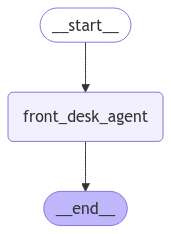

In [55]:
#----------------- Build Fucntions that Agents use ----------------------

def patient_verification_tool(image_Path, selected_patient_data,  updated_patient_df) -> str:
    """Detects the gender from an image provided as a file path."""
    from PIL import Image
    print(image_Path)
    model = AutoModelForImageClassification.from_pretrained("rizvandwiki/gender-classification")
    processor = AutoProcessor.from_pretrained("rizvandwiki/gender-classification")
    image = Image.open(image_Path)
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    predicted_class = outputs.logits.argmax(-1).item()
    print(f"Predicted Gender Of Patient is : {model.config.id2label[predicted_class]}")
    predicted_gender = model.config.id2label[predicted_class]

    from PIL import Image
    model = AutoModelForImageClassification.from_pretrained("nateraw/vit-age-classifier")
    processor = AutoProcessor.from_pretrained("nateraw/vit-age-classifier")
    image = Image.open(image_Path)
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    predicted_class = outputs.logits.argmax(-1).item()
    print(f"predicted Age Class: {model.config.id2label[predicted_class]}")
    predicted_age_range = model.config.id2label[predicted_class]

    # Parse the age range string (e.g., "20-29")
    age_min, age_max = map(int, predicted_age_range.split('-'))
    print(f"age_mi: {age_min}, age_max: {age_max}")

    # Verify against the DataFrame
    matching_row = updated_patient_df[
        (updated_patient_df["First_Name"] == selected_patient["First_Name"]) &
        (updated_patient_df["Last_Name"] == selected_patient["Last_Name"]) &
        (updated_patient_df["Patient_ID"] == selected_patient["Patient_ID"]) &
        (updated_patient_df["Gender"].str.lower() == predicted_gender) &
        (updated_patient_df["Age"].between(age_min, age_max))
    ]
    print(f"matching_row {matching_row} ")
    if not matching_row.empty:
        patient_verification = f'''Verification successful.
                        Patient is : {selected_patient["First_Name"]} {selected_patient["Last_Name"]}
                        with ID {selected_patient["Patient_ID"]}
                        which is {predicted_gender} in age range of {predicted_age_range} can proceed to the physician.'''
    else:
      patient_verification = "ID not verified. Patient cannot proceed."
    return patient_verification

#------------------- Define Agents-----------------------------

class AgentState(TypedDict):
    initial_prompt : str
    messages: Annotated[List[BaseMessage], operator.add]
    patient_verification : str

def front_desk_agent(state, image_Path, selected_patient_data,  updated_patient_df):
    initial_prompt = state["initial_prompt"]
    # Call function
    patient_verification =  patient_verification_tool(image_Path, selected_patient_data,  updated_patient_df)
    print(patient_verification)
    return {"patient_verification": patient_verification}

#-----------------------------------------------------------------
#               Build the LangGraph for Hospital Front Desk     #
#-----------------------------------------------------------------

image_Path = "/content/sample_data/female.jpg"
selected_patient_data = selected_patient.to_dict()
updated_patient_df


front_desk_agent_node = functools.partial(front_desk_agent,
                                          image_Path = image_Path,
                                          selected_patient_data=selected_patient_data,
                                          updated_patient_df =updated_patient_df)

# 6. Set up the Langgraph state graph
FrontDeskGraph = StateGraph(AgentState)

# Define nodes for workflow
FrontDeskGraph.add_node("front_desk_agent", front_desk_agent_node)
FrontDeskGraph.add_edge(START, "front_desk_agent")
FrontDeskGraph.add_edge("front_desk_agent", END)


# Initialize memory to persist state between graph runs
FrontDeskWorkflow = FrontDeskGraph.compile()

from IPython.display import Markdown, display, Image
display(Image(FrontDeskWorkflow.get_graph(xray=True).draw_mermaid_png()))


In [59]:
initial_prompt = "You are Front Desk Administrator in an Hospital in the Netherlands. Start Verification of the following Patient:"


# Run the workflow
inputs = {"initial_prompt" : initial_prompt
          }
output = FrontDeskWorkflow.invoke(inputs)
output

/content/sample_data/female.jpg
Predicted Gender Of Patient is : female


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


predicted Age Class: 20-29
age_mi: 20, age_max: 29
matching_row      Disease Fever Cough Fatigue Difficulty Breathing  Age  Gender  \
4  Influenza   Yes   Yes     Yes                  Yes   25  Female   

  Blood Pressure Cholesterol Level Outcome Variable First_Name     Last_Name  \
4         Normal            Normal         Positive     Mirjam  Vanderhoeven   

             Patient_ID  
4  T2V4M5B6G4L8J4L1F7J2   
Verification successful.
                        Patient is : Mirjam Vanderhoeven
                        with ID T2V4M5B6G4L8J4L1F7J2
                        which is female in age range of 20-29 can proceed to the physician.


{'initial_prompt': 'You are Front Desk Administrator in an Hospital in the Netherlands. Start Verification of the following Patient:',
 'messages': [],
 'patient_verification': 'Verification successful.\n                        Patient is : Mirjam Vanderhoeven\n                        with ID T2V4M5B6G4L8J4L1F7J2\n                        which is female in age range of 20-29 can proceed to the physician.'}

In [60]:
display(Markdown(output['patient_verification']))

Verification successful.
                        Patient is : Mirjam Vanderhoeven
                        with ID T2V4M5B6G4L8J4L1F7J2
                        which is female in age range of 20-29 can proceed to the physician.

## 3.2 Pysician Agent

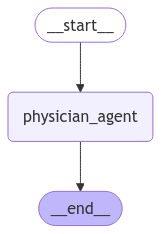

In [61]:
def question_patient_symptoms(selected_patient_data) -> str:
    """Asks the patient about symptoms, generates responses, and summarizes the answers based on patient data."""
    symptoms_questions = {
        "Cough": "\nAre you coughing?\n",
        "Fatigue": "\nDo you feel fatigue?\n",
        "\nDifficulty Breathing": "Do you have difficulty breathing?\n"
    }

    conversation = []

    for symptom, question in symptoms_questions.items():
        conversation.append(f"\nPhysician: {question}")
        response = selected_patient_data.get(symptom, "No")
        answer = "Yes" if response == "Yes" else "No"
        conversation.append(f"\nPatient: {answer}")

    first_name = selected_patient_data.get("First_Name", "")
    last_name = selected_patient_data.get("Last_Name", "")
    patient_id = selected_patient_data.get("Patient_ID", "")
    gender = selected_patient_data.get("Gender", "")
    age = selected_patient_data.get("Age", "")

    profile = f"\nYou are {first_name} {last_name}, a {age} years old {gender} with Patient ID: {patient_id}."
    summary = profile +"I gathered that you are experiencing the following: "
    summaries = []
    for symptom in symptoms_questions.keys():
        response = selected_patient_data.get(symptom, "No")
        if response == "Yes":
            summaries.append(f"you are experiencing {symptom.lower()}")
        else:
            summaries.append(f"\nI am glad you are not experiencing {symptom.lower()}")
    summary += "; ".join(summaries) + "."

    conversation.append(f"\nPhysician: {summary}")

    return "\n".join(conversation)

def perform_examination(selected_patient_data) -> str:
    """Performs examination by reporting fever, blood pressure, and cholesterol level from patient data."""
    fever = selected_patient_data.get("Fever", "Unknown")
    blood_pressure = selected_patient_data.get("Blood Pressure", "Unknown")
    cholesterol = selected_patient_data.get("Cholesterol Level", "Unknown")
    return f"Examination Results: Fever - {fever}, Blood Pressure - {blood_pressure}, Cholesterol Level - {cholesterol}"

def diagnose_patient(selected_patient_data) -> str:
    """Provides diagnosis based on Disease and Outcome columns in patient data."""
    disease = selected_patient_data.get("Disease", "Unknown Disease")
    outcome = selected_patient_data.get("Outcome Variable", "Unknown Outcome")
    if outcome == 'Positive':
      diagnosis = 'Make X-Ray from Chest'
    else:
      diagnosis = 'Rest to Recover'
    return f"Diagnosis: {disease}. Test Result: {outcome}. Final Diagnosis: {diagnosis}", diagnosis


class AgentState(TypedDict):
    initial_prompt : str
    messages: Annotated[List[BaseMessage], operator.add]
    question_patient_symptoms: str
    examination_patient: str
    diagnosis_patient: str
    diagnosis : str


def physician_agent(state, selected_patient_data):
    question_patient= question_patient_symptoms(selected_patient_data)
    examination = perform_examination(selected_patient_data)
    diagnosis_report, diagnosis  = diagnose_patient(selected_patient_data)
    return {"question_patient_symptoms": question_patient,
            "examination_patient": examination,
            "diagnosis_patient": diagnosis_report,
            "diagnosis": diagnosis}


selected_patient_data = selected_patient.to_dict()

physician_agent_node = functools.partial(physician_agent,
                                          selected_patient_data=selected_patient_data)


# 6. Set up the Langgraph state graph
PhysicianGraph = StateGraph(AgentState)

# Define nodes for workflow
PhysicianGraph.add_node("physician_agent", physician_agent_node)
PhysicianGraph.add_edge(START, "physician_agent")
PhysicianGraph.add_edge("physician_agent", END)


# Initialize memory to persist state between graph runs
PhysicianWorkflow = PhysicianGraph.compile()

display(Image(PhysicianWorkflow.get_graph(xray=True).draw_mermaid_png()))


In [62]:
initial_prompt = "You are a very experienced Doctor in an Hospital in the Netherlands. Start a conversation with the patient and determine \
                   symptoms and give diagnosis"


# Run the workflow
inputs = {"initial_prompt" : initial_prompt
          }
output = PhysicianWorkflow.invoke(inputs)
output

{'initial_prompt': 'You are a very Experienced Doctor in an Hospital in the Netherlands. Start a conversation with the patient and determine                    symptoms and give diagnosis',
 'messages': [],
 'question_patient_symptoms': '\nPhysician: \nAre you coughing?\n\n\nPatient: Yes\n\nPhysician: \nDo you feel fatigue?\n\n\nPatient: Yes\n\nPhysician: Do you have difficulty breathing?\n\n\nPatient: No\n\nPhysician: \nYou are Mirjam Vanderhoeven, a 25 years old Female with Patient ID: T2V4M5B6G4L8J4L1F7J2.I gathered that you are experiencing the following: you are experiencing cough; you are experiencing fatigue; \nI am glad you are not experiencing \ndifficulty breathing.',
 'examination_patient': 'Examination Results: Fever - Yes, Blood Pressure - Normal, Cholesterol Level - Normal',
 'diagnosis_patient': 'Diagnosis: Influenza. Test Result: Positive. Final Diagnosis: Make X-Ray from Chest',
 'diagnosis': 'Make X-Ray from Chest'}

In [63]:
display(Markdown(output['question_patient_symptoms']))
display(Markdown(output['examination_patient']))
display(Markdown(output['diagnosis_patient']))


Physician: 
Are you coughing?


Patient: Yes

Physician: 
Do you feel fatigue?


Patient: Yes

Physician: Do you have difficulty breathing?


Patient: No

Physician: 
You are Mirjam Vanderhoeven, a 25 years old Female with Patient ID: T2V4M5B6G4L8J4L1F7J2.I gathered that you are experiencing the following: you are experiencing cough; you are experiencing fatigue; 
I am glad you are not experiencing 
difficulty breathing.

Examination Results: Fever - Yes, Blood Pressure - Normal, Cholesterol Level - Normal

Diagnosis: Influenza. Test Result: Positive. Final Diagnosis: Make X-Ray from Chest

## 3.3 Radiologist

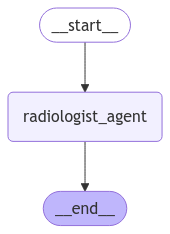

In [64]:
def examine_X_ray_image(patient_x_ray_path) -> str:
    """Use Vision Models to recognise if the X-Ray Image of Patient is NORMAL or PNEUMONIA"""
    # Model in Hugging Face: https://huggingface.co/lxyuan/vit-xray-pneumonia-classification
    # vit-xray-pneumonia-classification
    x_ray_ds = load_dataset(patient_x_ray_path, name="full")
    random_index = random.randint(0, x_ray_ds['train'].shape[0] - 1)
    patient_x_ray_image  = x_ray_ds['train'][random_index]['image']
    classifier = pipeline(model="lxyuan/vit-xray-pneumonia-classification")
    patient_x_ray_results = classifier(patient_x_ray_image)

    # Find the label with the highest score and its score
    highest = max(patient_x_ray_results, key=lambda x: x['score'])
    highest_score_label = highest['label']
    highest_score = highest['score'] * 100  # Convert to percentage

    # Choose the correct verb based on the label
    verb = "is" if highest_score_label == "NORMAL" else "has"

    return f"Patient {verb} {highest_score_label} with Probability of ca. {highest_score:.0f}%"

class AgentState(TypedDict):
    initial_prompt : str
    messages: Annotated[List[BaseMessage], operator.add]
    pneumonia_detection: str



def radiologist_agent(state, patient_x_ray_path):
    pneumonia_detection = examine_X_ray_image(patient_x_ray_path)
    return {"pneumonia_detection": pneumonia_detection}

patient_x_ray_path = "keremberke/chest-xray-classification"

radiologist_agent_node = functools.partial(radiologist_agent,
                                          patient_x_ray_path=patient_x_ray_path)

# 6. Set up the Langgraph state graph
RadiologistGraph = StateGraph(AgentState)

# Define nodes for workflow
RadiologistGraph.add_node("radiologist_agent", radiologist_agent_node)
RadiologistGraph.add_edge(START, "radiologist_agent")
RadiologistGraph.add_edge("radiologist_agent", END)

# Initialize memory to persist state between graph runs
RadiologistWorkflow = RadiologistGraph.compile()

display(Image(RadiologistWorkflow.get_graph(xray=True).draw_mermaid_png()))


In [65]:
initial_prompt = "You are a Very Experienced Radiologist in an Hospital in the Netherlands. Diagnose if the patient has pneumonia"


# Run the workflow
inputs = {"initial_prompt" : initial_prompt
          }
output = RadiologistWorkflow.invoke(inputs)
output

Device set to use cpu


{'initial_prompt': 'You are a Very Experienced Radiologist in an Hospital in the Netherlands. Diagnose if the patient has pneumonia',
 'messages': [],
 'pneumonia_detection': 'Patient has PNEUMONIA with Probability of ca. 92%'}

In [66]:
display(Markdown(output['pneumonia_detection']))

Patient has PNEUMONIA with Probability of ca. 92%

# Step 4: Putting All Agents in One Graph

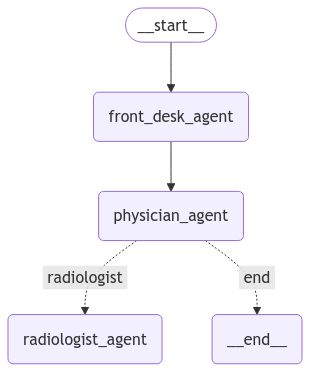

In [67]:
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.prompts import ChatPromptTemplate

selected_patient_data = selected_patient.to_dict()
image_Path = "/content/sample_data/female.jpg"
patient_x_ray_image = patient_x_ray

def patient_verification_tool(image_Path, selected_patient_data,  updated_patient_df) -> str:
    """Detects the gender from an image provided as a file path."""
    from PIL import Image
    print(image_Path)
    model = AutoModelForImageClassification.from_pretrained("rizvandwiki/gender-classification")
    processor = AutoProcessor.from_pretrained("rizvandwiki/gender-classification")
    image = Image.open(image_Path)
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    predicted_class = outputs.logits.argmax(-1).item()
    print(f"Predicted Gender Of Patient is : {model.config.id2label[predicted_class]}")
    predicted_gender = model.config.id2label[predicted_class]

    from PIL import Image
    model = AutoModelForImageClassification.from_pretrained("nateraw/vit-age-classifier")
    processor = AutoProcessor.from_pretrained("nateraw/vit-age-classifier")
    image = Image.open(image_Path)
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    predicted_class = outputs.logits.argmax(-1).item()
    print(f"predicted Age Class: {model.config.id2label[predicted_class]}")
    predicted_age_range = model.config.id2label[predicted_class]

    # Parse the age range string (e.g., "20-29")
    age_min, age_max = map(int, predicted_age_range.split('-'))
    print(f"age_mi: {age_min}, age_max: {age_max}")

    # Verify against the DataFrame
    matching_row = updated_patient_df[
        (updated_patient_df["First_Name"] == selected_patient["First_Name"]) &
        (updated_patient_df["Last_Name"] == selected_patient["Last_Name"]) &
        (updated_patient_df["Patient_ID"] == selected_patient["Patient_ID"]) &
        (updated_patient_df["Gender"].str.lower() == predicted_gender) &
        (updated_patient_df["Age"].between(age_min, age_max))
    ]
    print(f"matching_row {matching_row} ")
    if not matching_row.empty:
        patient_verification = f'''Verification successful.
                        Patient is : {selected_patient["First_Name"]} {selected_patient["Last_Name"]}
                        with ID {selected_patient["Patient_ID"]}
                        which is {predicted_gender} in age range of {predicted_age_range} can proceed to the physician.'''
    else:
      patient_verification = "ID not verified. Patient cannot proceed."
    return patient_verification

def question_patient_symptoms(selected_patient_data) -> str:
    """Asks the patient about symptoms, generates responses, and summarizes the answers based on patient data."""
    symptoms_questions = {
        "Cough": "\nAre you coughing?\n",
        "Fatigue": "\nDo you feel fatigue?\n",
        "\nDifficulty Breathing": "Do you have difficulty breathing?\n"
    }

    conversation = []

    for symptom, question in symptoms_questions.items():
        conversation.append(f"\nPhysician: {question}")
        response = selected_patient_data.get(symptom, "No")
        answer = "Yes" if response == "Yes" else "No"
        conversation.append(f"\nPatient: {answer}")

    first_name = selected_patient_data.get("First_Name", "")
    last_name = selected_patient_data.get("Last_Name", "")
    patient_id = selected_patient_data.get("Patient_ID", "")
    gender = selected_patient_data.get("Gender", "")
    age = selected_patient_data.get("Age", "")

    profile = f"\nYou are {first_name} {last_name}, a {age} years old {gender} with Patient ID: {patient_id}."
    summary = profile +"I gathered that you are experiencing the following: "
    summaries = []
    for symptom in symptoms_questions.keys():
        response = selected_patient_data.get(symptom, "No")
        if response == "Yes":
            summaries.append(f"you are experiencing {symptom.lower()}")
        else:
            summaries.append(f"\nI am glad you are not experiencing {symptom.lower()}")
    summary += "; ".join(summaries) + "."

    conversation.append(f"\nPhysician: {summary}")

    return "\n".join(conversation)

def perform_examination(selected_patient_data) -> str:
    """Performs examination by reporting fever, blood pressure, and cholesterol level from patient data."""
    fever = selected_patient_data.get("Fever", "Unknown")
    blood_pressure = selected_patient_data.get("Blood Pressure", "Unknown")
    cholesterol = selected_patient_data.get("Cholesterol Level", "Unknown")
    return f"Examination Results: Fever - {fever}, Blood Pressure - {blood_pressure}, Cholesterol Level - {cholesterol}"

def diagnose_patient(selected_patient_data) -> str:
    """Provides diagnosis based on Disease and Outcome columns in patient data."""
    disease = selected_patient_data.get("Disease", "Unknown Disease")
    outcome = selected_patient_data.get("Outcome Variable", "Unknown Outcome")
    if outcome == 'Positive':
      diagnosis = 'Make X-Ray from Chest'
    else:
      diagnosis = 'Rest to Recover'
    return f"Diagnosis: {disease}. Test Result: {outcome}. Final Diagnosis: {diagnosis}", diagnosis

def examine_X_ray_image(patient_x_ray_path) -> str:
    """Use Vision Models to recognise if the X-Ray Image of Patient is NORMAL or PNEUMONIA"""
    # Model in Hugging Face: https://huggingface.co/lxyuan/vit-xray-pneumonia-classification
    # vit-xray-pneumonia-classification
    x_ray_ds = load_dataset(patient_x_ray_path, name="full")
    random_index = random.randint(0, x_ray_ds['train'].shape[0] - 1)
    patient_x_ray_image  = x_ray_ds['train'][random_index]['image']
    classifier = pipeline(model="lxyuan/vit-xray-pneumonia-classification")
    patient_x_ray_results = classifier(patient_x_ray_image)

    # Find the label with the highest score and its score
    highest = max(patient_x_ray_results, key=lambda x: x['score'])
    highest_score_label = highest['label']
    highest_score = highest['score'] * 100  # Convert to percentage

    # Choose the correct verb based on the label
    verb = "is" if highest_score_label == "NORMAL" else "has"

    return f"Patient {verb} {highest_score_label} with Probability of ca. {highest_score:.0f}%"

# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    initial_prompt : str
    messages: Annotated[List[BaseMessage], operator.add]
    patient_verification : str
    question_patient_symptoms: str
    examination_patient: str
    diagnosis_patient: str
    diagnosis : str
    pneumonia_detection: str

def front_desk_agent(state, image_Path, selected_patient_data,  updated_patient_df):
    initial_prompt = state["initial_prompt"]
    patient_verification =  patient_verification_tool(image_Path, selected_patient_data,  updated_patient_df)
    print(patient_verification)
    return {"patient_verification": patient_verification}

def physician_agent(state, selected_patient_data):
    question_patient= question_patient_symptoms(selected_patient_data)
    examination = perform_examination(selected_patient_data)
    diagnosis_report, diagnosis  = diagnose_patient(selected_patient_data)
    pneumonia_detection = examine_X_ray_image(patient_x_ray_path)
    return {"question_patient_symptoms": question_patient,
            "examination_patient": examination,
            "diagnosis_patient": diagnosis_report,
            "diagnosis": diagnosis}

def radiologist_agent(state, patient_x_ray_path):
    pneumonia_detection = examine_X_ray_image(patient_x_ray_path)
    return {"pneumonia_detection": pneumonia_detection}

def decide_on_radiologist(state):
  if state["diagnosis"] == 'Make X-Ray from Chest':
    return 'radiologist'
  else:
    return ''


image_Path = "/content/sample_data/female.jpg"
selected_patient_data = selected_patient.to_dict()
updated_patient_df
patient_x_ray_path = "keremberke/chest-xray-classification"

front_desk_agent_node = functools.partial(front_desk_agent,
                                          image_Path = image_Path,
                                          selected_patient_data=selected_patient_data,
                                          updated_patient_df =updated_patient_df)
physician_agent_node = functools.partial(physician_agent,
                                          selected_patient_data=selected_patient_data)

radiologist_agent_node = functools.partial(radiologist_agent,
                                          patient_x_ray_path=patient_x_ray_path)

def decide_on_radiologist(state):
  if state["diagnosis"] == 'Make X-Ray from Chest':
    return 'radiologist'
  else:
    return 'end'

# 6. Set up the Langgraph state graph
HospitalGraph = StateGraph(AgentState)

# Define nodes for workflow
HospitalGraph.add_node("front_desk_agent", front_desk_agent_node)
HospitalGraph.add_node("physician_agent", physician_agent_node)
HospitalGraph.add_node("radiologist_agent", radiologist_agent_node)

HospitalGraph.add_edge(START, "front_desk_agent")
HospitalGraph.add_edge("front_desk_agent", "physician_agent")
HospitalGraph.add_conditional_edges("physician_agent",
                                    decide_on_radiologist,
                                    {'radiologist': "radiologist_agent",
                                     'end': END})


# Initialize memory to persist state between graph runs
HospitalWorkflow = HospitalGraph.compile()

display(Image(HospitalWorkflow.get_graph(xray=True).draw_mermaid_png()))


In [68]:
initial_prompt = "Start with the following Patient"


# Run the workflow
inputs = {"initial_prompt" : initial_prompt
          }
output = HospitalWorkflow.invoke(inputs)
output

/content/sample_data/female.jpg
Predicted Gender Of Patient is : female


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


predicted Age Class: 20-29
age_mi: 20, age_max: 29
matching_row      Disease Fever Cough Fatigue Difficulty Breathing  Age  Gender  \
4  Influenza   Yes   Yes     Yes                  Yes   25  Female   

  Blood Pressure Cholesterol Level Outcome Variable First_Name     Last_Name  \
4         Normal            Normal         Positive     Mirjam  Vanderhoeven   

             Patient_ID  
4  T2V4M5B6G4L8J4L1F7J2   
Verification successful.
                        Patient is : Mirjam Vanderhoeven
                        with ID T2V4M5B6G4L8J4L1F7J2
                        which is female in age range of 20-29 can proceed to the physician.


Device set to use cpu
Device set to use cpu


{'initial_prompt': 'Start with the following Patient',
 'messages': [],
 'patient_verification': 'Verification successful.\n                        Patient is : Mirjam Vanderhoeven\n                        with ID T2V4M5B6G4L8J4L1F7J2\n                        which is female in age range of 20-29 can proceed to the physician.',
 'question_patient_symptoms': '\nPhysician: \nAre you coughing?\n\n\nPatient: Yes\n\nPhysician: \nDo you feel fatigue?\n\n\nPatient: Yes\n\nPhysician: Do you have difficulty breathing?\n\n\nPatient: No\n\nPhysician: \nYou are Mirjam Vanderhoeven, a 25 years old Female with Patient ID: T2V4M5B6G4L8J4L1F7J2.I gathered that you are experiencing the following: you are experiencing cough; you are experiencing fatigue; \nI am glad you are not experiencing \ndifficulty breathing.',
 'examination_patient': 'Examination Results: Fever - Yes, Blood Pressure - Normal, Cholesterol Level - Normal',
 'diagnosis_patient': 'Diagnosis: Influenza. Test Result: Positive. Final Dia

In [69]:
display(Markdown(output['patient_verification']))


Verification successful.
                        Patient is : Mirjam Vanderhoeven
                        with ID T2V4M5B6G4L8J4L1F7J2
                        which is female in age range of 20-29 can proceed to the physician.

In [70]:
display(Markdown(output['question_patient_symptoms']))
display(Markdown(output['examination_patient']))
display(Markdown(output['diagnosis_patient']))


Physician: 
Are you coughing?


Patient: Yes

Physician: 
Do you feel fatigue?


Patient: Yes

Physician: Do you have difficulty breathing?


Patient: No

Physician: 
You are Mirjam Vanderhoeven, a 25 years old Female with Patient ID: T2V4M5B6G4L8J4L1F7J2.I gathered that you are experiencing the following: you are experiencing cough; you are experiencing fatigue; 
I am glad you are not experiencing 
difficulty breathing.

Examination Results: Fever - Yes, Blood Pressure - Normal, Cholesterol Level - Normal

Diagnosis: Influenza. Test Result: Positive. Final Diagnosis: Make X-Ray from Chest

In [71]:
display(Markdown(output['pneumonia_detection']))

Patient has PNEUMONIA with Probability of ca. 92%

# Step 5: Gradio Dashboard

## 5.1 Build the Hospital Dashboard APP

In [72]:
x_ray_image_path = '/content/sample_data/x-ray-chest.png'

import gradio as gr
info = (
        f"**First Name:** {selected_patient_data['First_Name']}\n\n"
        f"**Last Name:** {selected_patient_data['Last_Name']}\n\n"
        f"**Patient ID:** {selected_patient_data['Patient_ID']}"
    )

def verify_age_gender():
    """
    Function to verify age and gender.
    """
    # Placeholder logic: In a real scenario, perform necessary checks or computations
    initial_prompt = "You are Front Desk Administrator in an Hospital in the Netherlands. Start Verification of the following Patient:"
    inputs = {"initial_prompt" : initial_prompt
          }
    output = FrontDeskWorkflow.invoke(inputs)
    verification_message = '✅ ' + output['patient_verification']
    return verification_message, gr.update(visible=True)

def physician_examination():
    initial_prompt = "You are a Very Experience Doctor in an Hospital in the Netherlands. Start a conversation with the patient and determine \
                   symptoms and give diagnosis"
    # Run the workflow
    inputs = {"initial_prompt" : initial_prompt
          }
    output = PhysicianWorkflow.invoke(inputs)
    output_all = f''' 🩺 {output['question_patient_symptoms']}\n
                     💓 {output['examination_patient']}\n
                     🌬️ {output['diagnosis_patient']}'''
    return output_all, gr.update(visible=True)

def pneumonia_detection():
    initial_prompt = "You are a Very Experienced Radiologist in an Hospital in the Netherlands. Diagnose if the patient has pneumonia"
    inputs = {"initial_prompt" : initial_prompt
          }
    output = RadiologistWorkflow.invoke(inputs)
    pneumonia_detection = 'From X-Ray Image 🖼️ ' + output['pneumonia_detection']
    return pneumonia_detection

def take_xray_image():

    return gr.update(visible=True), gr.update(visible=True)

with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column(scale=1):
            gr.Markdown(info)
            # Add a Button below the Markdown
            verify_button = gr.Button("Verify Age and Gender")
            # Add an output component to display verification status
            verification_output = gr.Textbox(label="Verification Status", interactive=False)
            # Add a Button below the Markdown
            physician_button = gr.Button("Get Examination at Physician", visible=False)
            physician_output = gr.Textbox(label="Examination by Physician Placeholder", interactive=False)
            x_ray_button = gr.Button("Take Chest X-Ray Image", visible=False)
            # Display X-Ray Image (Initially Hidden)
            xray_image_display = gr.Image(value=x_ray_image_path, label="X-Ray Image", visible=False)
            radiologist_button = gr.Button("Go to Radiologist", visible=False)
            # Add an output component to display verification status
            radiologist_output = gr.Textbox(label="Radiologist Placeholder", interactive=False)

        with gr.Column(scale=1):
            gr.Image(value=image_Path, label="Static Image", show_label=True)

    # Define the button's action: When clicked, call verify_age_gender and display the result
    verify_button.click(fn=verify_age_gender, inputs=None, outputs=[verification_output, physician_button])
    physician_button.click(fn=physician_examination, inputs=None, outputs=[physician_output, x_ray_button])
    x_ray_button.click(fn=take_xray_image, inputs=None, outputs=[xray_image_display, radiologist_button])
    radiologist_button.click(fn=pneumonia_detection, inputs=None, outputs=[radiologist_output])


## 5.2 Run the App

In [73]:
# Launch the app
demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://41f433501ac175c600.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Step 6: Building Advanced Retrieval (RAG)

## 6.1 Textsplitter

In [74]:
# Patient records (3 example patients)

text_content = ["Patient 1: Mette Smit, a 25 years old Female with Patient ID: X8g6eC2R7uPvN5a1."
                "Mette is coughing and is experiencing fatigue. Mette has fever and Influenza."
                "Mette has Pneuomnia with Probability of ca. 92%."
                "Patient 2: Tim Sutherland has fever and suffer from difficuly in breathing.",
                "We made an X-Ray Image from Tim Sutherland chest.",
                "Radiologist give Tim Sutherland 93% chance of Pneuomnia",
                "Patient 3: Jane Bright has no fever and suffer from high blood pressure and high chlostole.",
                "We made an X-Ray Image from Jane Bright chest because of non-stop caughing",
                "Radiologist give only 8% chance of Pneuomnia for Jane. It seems that Jane Bright has an influenza",]

documents = [Document(page_content=text) for text in text_content]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=20)
splits = text_splitter.split_documents(documents)
splits

[Document(metadata={}, page_content='Patient 1: Mette Smit, a 25 years old Female with Patient ID: X8g6eC2R7uPvN5a1.Mette is coughing and'),
 Document(metadata={}, page_content='is coughing and is experiencing fatigue. Mette has fever and Influenza.Mette has Pneuomnia with'),
 Document(metadata={}, page_content='has Pneuomnia with Probability of ca. 92%.Patient 2: Tim Sutherland has fever and suffer from'),
 Document(metadata={}, page_content='and suffer from difficuly in breathing.'),
 Document(metadata={}, page_content='We made an X-Ray Image from Tim Sutherland chest.'),
 Document(metadata={}, page_content='Radiologist give Tim Sutherland 93% chance of Pneuomnia'),
 Document(metadata={}, page_content='Patient 3: Jane Bright has no fever and suffer from high blood pressure and high chlostole.'),
 Document(metadata={}, page_content='We made an X-Ray Image from Jane Bright chest because of non-stop caughing'),
 Document(metadata={}, page_content='Radiologist give only 8% chance of Pneu

In [75]:
text_chunks = []
for page in splits:
    chunks = text_splitter.split_text(page.page_content)
    text_chunks.extend(chunks)
text_chunks

['Patient 1: Mette Smit, a 25 years old Female with Patient ID: X8g6eC2R7uPvN5a1.Mette is coughing and',
 'is coughing and is experiencing fatigue. Mette has fever and Influenza.Mette has Pneuomnia with',
 'has Pneuomnia with Probability of ca. 92%.Patient 2: Tim Sutherland has fever and suffer from',
 'and suffer from difficuly in breathing.',
 'We made an X-Ray Image from Tim Sutherland chest.',
 'Radiologist give Tim Sutherland 93% chance of Pneuomnia',
 'Patient 3: Jane Bright has no fever and suffer from high blood pressure and high chlostole.',
 'We made an X-Ray Image from Jane Bright chest because of non-stop caughing',
 'Radiologist give only 8% chance of Pneuomnia for Jane. It seems that Jane Bright has an influenza']

## 6.2 Embedding

In [76]:
hf_embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
embeddings = hf_embeddings.embed_documents(text_chunks)

<ipython-input-76-42a8d0eeb6b5>:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  hf_embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## 6.3 Vector Database

In [77]:
persist_directory = '/content/sample_data/chrmoadb'

vectordb = Chroma.from_documents(documents=splits,
                                 embedding=hf_embeddings,
                                 persist_directory=persist_directory)

## 6.4 LLM | Groq + Llama 3.3

In [78]:
os.environ["GROQ_API_KEY"] = GROQ_API_KEY

# Model 3.2 is removed from Groq platform
# So we use the Newest one: 3.3

model_3_3 ='llama-3.3-70b-versatile'

llm = ChatGroq(
    model=model_3_3,
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

## 6.5 Query Prompt

In [79]:
QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an AI language model assistant. Your task is to generate five
    different versions of the given user question to retrieve relevant documents from
    a vector database. By generating multiple perspectives on the user question, your
    goal is to help the user overcome some of the limitations of the distance-based
    similarity search. Provide these alternative questions separated by newlines.
    Original question: {question}""",
)

## 6.6 Retriever

In [80]:
overall_retriever = MultiQueryRetriever.from_llm(
                                          vectordb.as_retriever(),
                                          llm,
                                          prompt=QUERY_PROMPT
)

# RAG prompt
template = """Answer the question based ONLY on the following context:
{context}
Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

## 6.7 Chain

In [81]:
chain = (
    {"context": overall_retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# Step 7: Chatting with RAG

In [82]:
questions = '''What are the names of all the patients in the database?'''
display(Markdown(chain.invoke(questions)))

The names of the patients mentioned in the database are:

1. Jane Bright
2. Tim Sutherland
3. Mette Smit

In [83]:
questions = '''What are all the health issues that Jane Bright has?'''
display(Markdown(chain.invoke(questions)))

Based on the provided context, Jane Bright has the following health issues:

1. High blood pressure
2. High cholesterol
3. Influenza
4. Difficulty in breathing
5. Non-stop coughing 

Note that the radiologist gives only an 8% chance of pneumonia for Jane, but it is not confirmed as a definite health issue.

In [84]:
questions = '''What are all the health issues that Mette Smit has?'''
display(Markdown(chain.invoke(questions)))

Mette Smit has the following health issues:

1. Coughing
2. Fatigue
3. Fever
4. Influenza
5. Pneumonia (with a probability of 92%)
6. Difficulty in breathing.

In [85]:
questions = '''What is the age of Tim Sutherland?'''
display(Markdown(chain.invoke(questions)))

The age of Tim Sutherland is not mentioned in the given context.

In [ ]:
questions = '''Which patient has a Patient ID?'''
display(Markdown(chain.invoke(questions)))